In [1]:
# References:
# https://github.com/marshackVB/ml-recipes/blob/master/PandasUDF_Hyperopt_Spark.ipynb
# https://www.phdata.io/blog/bayesian-hyperparameter-optimization-with-mlflow/
import numpy as np
import pandas as pd
from datetime import date,datetime,timedelta

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import StringType, DoubleType, StructType, StructField, DateType, FloatType
from pyspark.sql.functions import *


# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '10gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

import os
from functions.func import *

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
# Load models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

/opt/conda/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. Paramaters

In [3]:
experiment_name = "forecast_pyspark"
days_to_forecast = 14
last_train_date = date(2021, 12, 31)
use_sample_data = True
multiple_models = True # Currently Xgboost and RandomForest

if not multiple_models:
    model_name = 'xgboost'  # 'randomforest'
    model = XGBRegressor if model_name == 'xgboost' else RandomForestRegressor

# 2. Data Input

In [4]:
df_input = sqlContext.read.parquet("sample_data/sample_data.parquet")

In [5]:
if not use_sample_data:
    # to read parquet file
    df_input = sqlContext.read.parquet('data/forecast_encoded_data.parquet')
    df_input = df_input.filter( ( col('Key1') == 'N01') & (col('Key2').isin(['76', '62']) ) )

    unique_ts = df_input_train.select(['Key1', 'Key2']).drop_duplicates().toPandas()
    
label_col = 'y'
feature_cols = [column for column in df_input.columns if column not in [label_col, 'ds', 'Forecast', 'Key1','Key2']]

df_input_train = df_input.filter(col('ds') <= last_train_date )
df_input_test = df_input.filter(col('ds') > last_train_date )

In [6]:
check_key1 = 'N01'
check_key2 = '76'
df_input_train.filter( (col('Key1') == check_key1) &  (col('Key2') == check_key2) & (col('ds') > '2021-11-01')  ).sort(col('ds')).show()

+----+----+-------------------+----+-----+---------+---+
|Key1|Key2|                 ds|year|month|dayofweek|  y|
+----+----+-------------------+----+-----+---------+---+
| N01|  76|2021-11-02 00:00:00|2021|   11|        3|100|
| N01|  76|2021-11-03 00:00:00|2021|   11|        4|189|
| N01|  76|2021-11-04 00:00:00|2021|   11|        5|313|
| N01|  76|2021-11-05 00:00:00|2021|   11|        6|311|
| N01|  76|2021-11-06 00:00:00|2021|   11|        7| 59|
| N01|  76|2021-11-07 00:00:00|2021|   11|        1|  0|
| N01|  76|2021-11-08 00:00:00|2021|   11|        2|221|
| N01|  76|2021-11-09 00:00:00|2021|   11|        3|228|
| N01|  76|2021-11-10 00:00:00|2021|   11|        4| 72|
| N01|  76|2021-11-11 00:00:00|2021|   11|        5|335|
| N01|  76|2021-11-12 00:00:00|2021|   11|        6|302|
| N01|  76|2021-11-13 00:00:00|2021|   11|        7| 70|
| N01|  76|2021-11-14 00:00:00|2021|   11|        1|  0|
| N01|  76|2021-11-15 00:00:00|2021|   11|        2|166|
| N01|  76|2021-11-16 00:00:00|

# 3. Model Training

In [8]:
# Hyperopt search space
search_space = {
  'n_estimators':scope.int(hp.uniform('n_estimators',150,500)),
  'max_depth':scope.int(hp.uniform('max_depth',3,15)),
  #'min_samples_leaf':scope.int(hp.uniform('min_samples_leaf',1,5)),
  #'min_samples_split':scope.int(hp.uniform('min_samples_split',2,6)), #num_features_for_split = sqrt(total_input_features)
  #'max_samples': hp.uniform("max_samples",0.5, 1)
}

# Pandas_UDF requires a Spark Schema that matches the output of the UDF
fit_schema = StructType([StructField('node', StringType(), True),
                         StructField('best_model_score', DoubleType(), True)])


if multiple_models:
    
    fit_multiple_models_config = fit_multiple_models(feature_cols = feature_cols, 
                               label_col = label_col,
                               models = [XGBRegressor, RandomForestRegressor],
                               search_space = search_space,
                               days_to_forecast = days_to_forecast,
                               experiment_name = experiment_name,
                               scoring = 'smape', # or sklearn scores, e.g. 'neg_mean_squared_error',
                               cv=2
                                )

    best_model_stats = df_input_train.groupBy('Key1','Key2').applyInPandas(fit_multiple_models_config, schema = fit_schema)
    
else:
    

    fit_models = fit_models_config(feature_cols = feature_cols, 
                                   label_col = label_col,
                                   model = model,
                                   search_space = search_space,
                                   days_to_forecast = days_to_forecast,
                                   experiment_name = experiment_name,
                                   scoring = 'smape', # or sklearn scores, e.g. 'neg_mean_squared_error',
                                   cv=3
                                    )

    best_model_stats = df_input_train.groupBy('Key1','Key2').applyInPandas(fit_models,schema=fit_schema)

In [9]:
%%time
best_model_stats.show()

+------+----------------+
|  node|best_model_score|
+------+----------------+
|N01_62|          0.4697|
|N01_76|          0.7198|
+------+----------------+

CPU times: user 44.1 ms, sys: 23.9 ms, total: 68 ms
Wall time: 5min 10s


## 3. Model Evaluation

In [10]:
# Define the schema for the UDF's output DataFrame
forecast_schema =StructType([
  StructField('ds',DateType()),
  StructField('Key1',StringType()),
  StructField('Key2',StringType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_lower',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('run_id',StringType())
  ])

experiment_id = '1'
apply_models = apply_models_config(features_cols = feature_cols,  experiment_id=experiment_id)

# 4. Plot

In [14]:
check_key1 = 'N01' # N01_62
check_key2 = '76'
group_name = '{}_{}'.format(check_key1, check_key2)
experiment_id = '1'

# extract the forecast for a specific ts_key as example
forecast = (df_input.filter((col("Key1") == check_key1) 
                             & (col("Key2") == check_key2))
                            .groupBy('Key1', 'Key2')
                            .applyInPandas(apply_models, schema = forecast_schema ))

forecast_pd = (
    forecast
    .select(['ds','y','yhat','yhat_lower','yhat_upper'])
    .filter((col('Key1')==check_key1) & (col('Key2')==check_key2))
    ).toPandas()


In [15]:
runs_df = mlflow.search_runs(experiment_id, order_by=["metrics.smape"])

In [17]:
runs_df.sort_values(by = ['end_time']).tail()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.smape,params.n_estimators,params.max_depth,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.ts_key,tags.model_type,tags.mlflow.log-model.history,tags..ipynb_checkpoints/mlflow.log-model-checkpoint.history,tags..ipynb_checkpoints/mlflow.source-checkpoint.type,tags..ipynb_checkpoints/ts_key-checkpoint,tags..ipynb_checkpoints/mlflow.source-checkpoint.name,tags..ipynb_checkpoints/model_type-checkpoint
15,3d0235820e9840e794e4665d117093e1,1,FINISHED,file:///home/jovyan/work/mlruns/1/3d0235820e98...,2022-07-30 12:05:23.225000+00:00,2022-07-30 12:06:12.520000+00:00,0.8343,158.90466061086153,6.912743800670197,/usr/local/spark/python/lib/pyspark.zip/pyspar...,jovyan,LOCAL,N01_62,XGBRegressor,"[{""run_id"": ""3d0235820e9840e794e4665d117093e1""...",None,None,None,None,None
4,e1542d1bd952480787d13815e020736c,1,FINISHED,file:///home/jovyan/work/mlruns/1/e1542d1bd952...,2022-07-30 12:06:12.550000+00:00,2022-07-30 12:07:39.048000+00:00,0.4697,235.58506813920087,6.0496761291166,/usr/local/spark/python/lib/pyspark.zip/pyspar...,jovyan,LOCAL,N01_62,RandomForestRegressor,"[{""run_id"": ""e1542d1bd952480787d13815e020736c""...",None,None,None,None,None
17,72d9bef70d93441b988793c09a0fe051,1,FINISHED,file:///home/jovyan/work/mlruns/1/72d9bef70d93...,2022-07-30 12:07:39.125000+00:00,2022-07-30 12:08:27.118000+00:00,1.0709,166.72580102483522,9.628797723298746,/usr/local/spark/python/lib/pyspark.zip/pyspar...,jovyan,LOCAL,N01_76,XGBRegressor,"[{""run_id"": ""72d9bef70d93441b988793c09a0fe051""...",None,None,None,None,None
10,9aff864f7d8d4555885088f0436fc9d6,1,FINISHED,file:///home/jovyan/work/mlruns/1/9aff864f7d8d...,2022-07-30 12:08:27.153000+00:00,2022-07-30 12:10:29.790000+00:00,0.7198,461.24777657262933,5.7909500175006405,/usr/local/spark/python/lib/pyspark.zip/pyspar...,jovyan,LOCAL,N01_76,RandomForestRegressor,"[{""run_id"": ""9aff864f7d8d4555885088f0436fc9d6""...",None,None,None,None,None
19,fd05b09c608546ea9bee0cff6c563988,1,RUNNING,file:///home/jovyan/work/mlruns/1/fd05b09c6085...,2022-07-30 12:04:27.920000+00:00,NaT,NaN,None,None,/usr/local/spark/python/lib/pyspark.zip/pyspar...,jovyan,LOCAL,None,None,None,None,None,None,None,None


In [19]:
model, best_run_df, model_cv_smape = load_model(check_key1, check_key2, experiment_id, group_name)

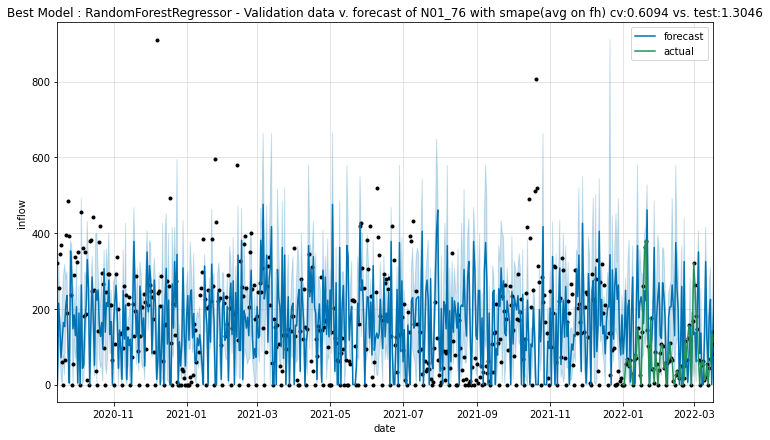

In [27]:
best_model_name = best_run_df['tags.model_type'].values[0]
plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name, best_model_name )

In [28]:
check_key1 = 'N01' # N01_62
check_key2 = '62'
group_name = '{}_{}'.format(check_key1, check_key2)
experiment_id = '1'

# extract the forecast for a specific ts_key as example
forecast = (df_input.filter((col("Key1") == check_key1) 
                             & (col("Key2") == check_key2))
                            .groupBy('Key1', 'Key2')
                            .applyInPandas(apply_models, schema = forecast_schema ))

# extract the forecast for a specific ts_key as example
forecast_pd = (
    forecast
    .select(['ds','y','yhat','yhat_lower','yhat_upper'])
    .filter((col('Key1')==check_key1) & (col('Key2')==check_key2))
    ).toPandas()

model, best_run_df, model_cv_smape = load_model(check_key1, check_key2, experiment_id, group_name)

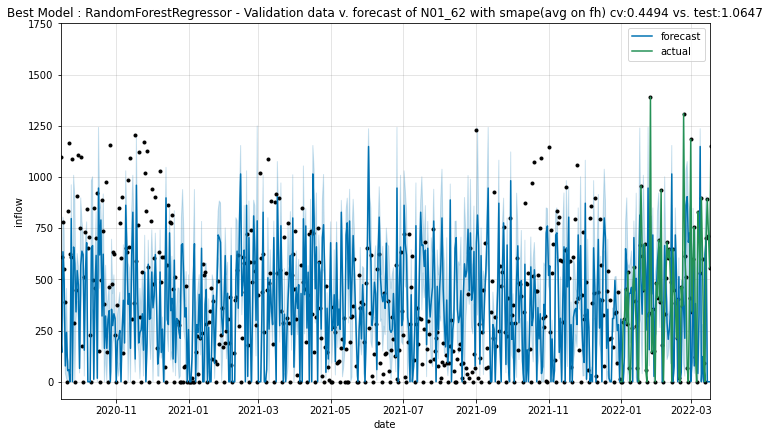

In [29]:
best_model_name = best_run_df['tags.model_type'].values[0]
plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name, best_model_name )